In [6]:
import os

os.environ["CHARMM_HOME"] = "/pchem-data/meuwly/boittier/home/charmm"
os.environ["CHARMM_LIB_DIR"] = "/pchem-data/meuwly/boittier/home/charmm/build/cmake"
# os.environ["MMTSBDIR"] = "/cluster/home/boittier/toolset/"
# sys.path.append(os.environ["MMTSBDIR"] + "perl")
# sys.path.append(os.environ["MMTSBDIR"] + "bin")

# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax

# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path

# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test")
import physnetjax

sys.path.append("/pchem-data/meuwly/boittier/home/dcm-lj-data")
from pycharmm_lingo_scripts import script1, script2, script3, load_dcm


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [7]:
import pycharmm

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm

import MDAnalysis as mda

import ase
from ase.io import read as read_ase
from ase import visualize
from ase.visualize import view

ev2kcalmol = 1/(ase.units.kcal / ase.units.mol)


def view_atoms(atoms):
    return view(atoms, viewer="x3d")

In [8]:
import ff_energy

In [9]:

from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import _prepare_batches as prepare_batches #prepare_batches, prepare_datasets

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)

from pathlib import Path

from physnetjax.calc.helper_mlp import get_ase_calc

In [10]:
def parse_non_int(s):
    return "".join([_ for _ in s if _.isalpha()]).lower().capitalize()

# Data 

In [11]:
data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")

In [12]:
import pandas as pd
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df

Cluster  Cluster Energy   Monomer Sum  Formation Energy (Hartree)  \
0     100_LIG_1   -19168.893238 -19168.826734                   -0.066504   
1    100_LIG_10   -19168.874696 -19168.806251                   -0.068444   
2   100_LIG_100   -19168.892131 -19168.828790                   -0.063341   
3    100_LIG_11   -19168.872941 -19168.815802                   -0.057139   
4    100_LIG_12   -19168.871378 -19168.821103                   -0.050275   
..          ...             ...           ...                         ...   
95   100_LIG_95   -19168.893409 -19168.829056                   -0.064353   
96   100_LIG_96   -19168.879736 -19168.820661                   -0.059075   
97   100_LIG_97   -19168.887691 -19168.826441                   -0.061250   
98   100_LIG_98   -19168.893152 -19168.828568                   -0.064584   
99   100_LIG_99   -19168.893152 -19168.828568                   -0.064584   

    Formation Energy (kcal/mol)  
0                    -41.731854  
1                    -42.949509  
2                    -39.747275  
3                    -35.855129  
4                    -31.547863  
..                          ...  
95                   -40.382115  
96                   -37.069863  
97                   -38.435091  
98                   -40.527012  
99                   -40.527012  

[100 rows x 5 columns]

# Load the pdb files

In [13]:
pdb_file = data_path / "dcmk" / "100_lig_1_modified.pdb"

In [14]:
loaded_pdb = mda.coordinates.PDB.PDBReader(pdb_file)
loaded_pdb = mda.topology.PDBParser.PDBParser(pdb_file)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [15]:
u = mda.Universe(pdb_file)

atom_names = [parse_non_int(s) for s in list(u.atoms.names)]
atom_positions = list(u.atoms.positions)
atomic_numbers = [ase.data.atomic_numbers[s] for s in atom_names]


In [16]:
ase_atoms = ase.Atoms(atomic_numbers, atom_positions)
view_atoms(ase_atoms)

# Run Pycharmm to get components of the energy

In [17]:
pycharmm.lingo.charmm_script(script1)
pycharmm.lingo.charmm_script(script2)

  
 CHARMM>     
  
 CHARMM>    set base     /pchem-data/meuwly/boittier/home/dcm-lj-data
 Parameter: BASE <- "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
  
 CHARMM>    set pardir   @base
 Parameter: BASE -> "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
 Parameter: PARDIR <- "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
  
 CHARMM>    set crddir   @base
 Parameter: BASE -> "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
 Parameter: CRDDIR <- "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
  
 CHARMM>     
  
 CHARMM>    PRNLev 5
  
 CHARMM>     
  
 CHARMM>     
  
 CHARMM>    read rtf card
 MAINIO> Residue topology file being read from unit  90.
 RDTITL> * METHANOL
 RDTITL> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
  
 CHARMM>     
  
 CHARMM>    read parameter card

          PARAMETER FILE BEING READ FROM UNIT 90
 RDTITL> * METHANO

1

In [18]:
pycharmm.lingo.charmm_script(load_dcm)

  
 CHARMM>     OPEN UNIT 40 CARD READ NAME @base/dcm.dcm
 Parameter: BASE -> "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/dcm-lj-data/dcm.dcm::
 OPNLGU> Unit 40 opened for READONLY access to /pchem-data/meuwly/boittier/home/dcm-lj-data/dcm.dcm
  
 CHARMM>    DCM IUDCM 40 TSHIFT
 DCM> INPUT FILE FOR DCM CHARGES: UNIT   40
 DCM> TIPNP SHIFT FUNCTION WILL BE USED FOR CUTOFFS
 DCM>          TOTAL DCM RESIDUES IN SYSTEM:      0
 DCM>          TOTAL DCM CHARGES IN SYSTEM:    100
  
 CHARMM>    CLOSE UNIT 40
 VCLOSE: Closing unit   40 with status "KEEP"
  
 CHARMM>     
  


1

In [19]:
energy.show()
vdw = energy.get_vdw()
elec = energy.get_elec()


 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    RDIElec  SWITch   VATOm    VSWItch 
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  =  8.000 CTEXNB =999.000 CTONNB =  6.500 CTOFNB =  7.500
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are        0 atom  pairs and        0 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.

      ***** LEVEL  1 WARNING FROM <GTNBCT> *****
      ***** CUTNB and CTOFNB are too close for efficient heuristic update.
      ******************************************
      BOMLEV (  0) IS NOT REACHED. WRNLEV IS  5

 <MAKINB> with mode   5 found    200 exclusions and      0 interactions(1-4)
 <MAKGRP> found      0 group exclusions.
 Generating nonbond list with Exclusion mode = 5
 == PRIMARY == SPACE FOR     4901 ATOM PAIRS AND        0 GROUP PAIRS

 General atom nonbond list generation found:
     1989 ATOM PAIRS WERE FOUND FOR ATOM LIST
      139 GROUP P

# Capture the neighbour lists

In [20]:
captured_output

NameError: name 'captured_output' is not defined

In [93]:
# Print something
distance_command = """
open unit 1 write form name total.dmat

COOR DMAT SINGLE UNIT 1 SELE ALL END SELE ALL END

close unit 1"""
_ = pycharmm.lingo.charmm_script(distance_command)

with open("total.dmat") as f:
    output_dmat = f.read()

atom_number_type_dict = {}
atom_number_resid_dict = {}

pair_distance_dict = {}
pair_resid_dict = {}

for _ in output_dmat.split("\n"):
    if _.startswith("*** "):
        _, n, resid, resname, at, _ = _.split()
    
        n = int(n.split("=")[0]) - 1
        atom_number_type_dict[n] = at
        atom_number_resid_dict[n] = int(resid) - 1
        
for _ in output_dmat.split("\n"):        
    if _.startswith("  "):
        a, b, dist = _.split()
        a = int(a) - 1
        b = int(b) - 1
        dist = float(dist)
        if (atom_number_resid_dict[a] < atom_number_resid_dict[b]):
            pair_distance_dict[(a, b)] = dist
            pair_resid_dict[(a, b)] = (atom_number_resid_dict[a], atom_number_resid_dict[b])


  
 CHARMM>     
  
 CHARMM>    open unit 1 write form name total.dmat
 VOPEN> Attempting to open::total.dmat::
 OPNLGU> Unit  1 opened for WRITE access to total.dmat
  
 CHARMM>     
  
 CHARMM>    COOR DMAT SINGLE UNIT 1 SELE ALL END SELE ALL END
 DMAT: Distance matrix output to unit   1
 SELRPN>    100 atoms have been selected out of    100
 SELRPN>    100 atoms have been selected out of    100
 DMAT: Number of atoms selected for SET1 100
 DMAT: Number of atoms selected for SET2 100
  
 CHARMM>     
  
 CHARMM>    close unit 1
 VCLOSE: Closing unit    1 with status "KEEP"
  


In [94]:
# validate that the neighbour list is the right length
len(set(pair_resid_dict.values()))

190

# Saving forces in pycharmm

In [92]:
positions = coor.get_positions()
force_command = """coor force sele all end"""

_ = pycharmm.lingo.charmm_script(force_command)
coor.get_positions()

x          y          z
0  -10.325306  12.083328 -25.099010
1   20.302888 -26.156992   7.709665
2   -3.156224  15.957056  23.166501
3   -6.362751  -2.785669  -2.264399
4    0.855564   0.694308  -2.633084
..        ...        ...        ...
95  -7.894563 -11.936396  31.997801
96  10.946558 -14.435898 -17.545644
97   0.318519  11.468979 -15.687482
98   8.636628   9.490333   3.870952
99 -13.503194   5.325277  -2.710899

[100 rows x 3 columns]

 CHARMM>     coor force sele all end
 SELRPN>    100 atoms have been selected out of    100
 SELECTED FORCES COPIED TO THE MAIN SET.

  


# get dimer contributions

In [17]:
from itertools import combinations

dimer_permutations = list(combinations(range(20), 2))
RANGE = len(dimer_permutations)

ele_energies = np.zeros(RANGE)
evdw_energies = np.zeros(RANGE)

for i, (a,b) in enumerate(dimer_permutations):
    a += 1
    b += 1
    print(a, b)
    block = f"""BLOCK 2
    CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
      CALL 2 SELE (RESID {a} .OR. RESID {b}) END
      COEFF 1 1 0.0
      COEFF 2 2 1.0
      COEFF 1 2 0.0
    END
    """
    _ = pycharmm.lingo.charmm_script(block)
    # print(_)
    energy.show()
    # energy.show()
    
    evdw = energy.get_vdw()
    evdw_energies[i] = evdw
    e = energy.get_elec()
    ele_energies[i] = e

    print(e)

1 2
  
 CHARMM>     BLOCK 2
  
  BLOCK>        CALL 1 SELE .NOT. (RESID 1 .OR. RESID 2) END
 SELRPN>     90 atoms have been selected out of    100
 The selected atoms have been reassigned to block   1
  
  BLOCK>          CALL 2 SELE (RESID 1 .OR. RESID 2) END
 SELRPN>     10 atoms have been selected out of    100
 The selected atoms have been reassigned to block   2
  
  BLOCK>          COEFF 1 1 0.0
  
  BLOCK>          COEFF 2 2 1.0
  
  BLOCK>          COEFF 1 2 0.0
  
  BLOCK>        END
 Matrix of Interaction Coefficients
 
    0.00000
    0.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    0.00000
    0.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    0.00000
    0.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    0.00000
    0.00000   1.00000
 Matrix of CROSS Interaction Coefficients
 
    0.00000
    0.00000   1.00000
 Matrix of ELEC Interaction Coefficients
 
    0.00000
    0.00000   1.00000
 Matrix of VDW Interaction Coefficients
 
 

In [18]:
# validate the sum of the two body terms matches charmm non-bonded terms
ele_energies.sum(), evdw_energies.sum()

(-1.839391943180564, -46.56664643871797)

# Fitting the ML model

In [14]:
# files = list(Path("/pchem-data/meuwly/boittier/home/pycharmm_test/data/basepairs").glob("*.npz"))
NATOMS = 10
files = [
    Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz"),

]

In [15]:
train_data, valid_data = prepare_datasets(
    data_key,
    16800,
     4199,
    files,
    clip_esp=False,
    natoms=NATOMS,
    clean=False,
    subtract_atom_energies=False,
    verbose=True,
)

ntest = len(valid_data["E"]) // 2
test_data = {k: v[ntest:] for k, v in valid_data.items()}
valid_data = {k: v[:ntest] for k, v in valid_data.items()}



                                   dcm_dimers_MP2_20999.npz                                    
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ N        ┃ E        ┃ Q        ┃ D          ┃ Z           ┃ R              ┃ F              ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ (20999,) │ (20999,) │ (20999,) │ (20999, 3) │ (20999, 10) │ (20999, 10, 3) │ (20999, 10, 3) │
└──────────┴──────────┴──────────┴────────────┴─────────────┴────────────────┴────────────────┘

dataR (20999, 10, 3)
dataE [-16.64463665 -16.84494252 -16.68936279 -16.69383745 -16.74775377
 -16.79686463 -16.70671807 -16.6819525  -16.70375592 -16.71621446]
dataE [-16.64463665 -16.84494252 -16.68936279 -16.69383745 -16.74775377
 -16.79686463 -16.70671807 -16.6819525  -16.70375592 -16.71621446]
D (20999, 3)
Q 1 (20999,) 20999
Q (20999,)


In [4]:
DEFAULT_DATA_KEYS = ["Z", "R", "D", "E", "F", "N"]
batch_size = 10

test_batches = prepare_batches(data_key, test_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=DEFAULT_DATA_KEYS)

train_batches = prepare_batches(data_key, train_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=DEFAULT_DATA_KEYS)

valid_batches = prepare_batches(data_key, valid_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=DEFAULT_DATA_KEYS)

In [97]:
# Eref = np.zeros([20], dtype=float)
# Eref[1] = -0.498232909223
# Eref[6] = -37.731440432799
# Eref[8] = -74.878159582108
# Eref[17] = -459.549260062932

In [6]:
model = EF(
    # attributes
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=64,
    cutoff=10.0,
    max_atomic_number=18,
    charges=True,
    natoms=NATOMS,
    total_charge=0,
    n_res=3,
    zbl=False,
    debug=False,
)

In [37]:
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-a31d3007-5046-4ae0-a16d-8e45aa2eafb1"
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-af722a47-a3a3-4f31-987f-c6a9ab2fb555"
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d8bc5d79-f65e-451e-8169-bf6da5170b54"
restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1"
params = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    num_epochs=int(1e6),
    learning_rate=0.0001,
    energy_weight=1,
    dipole_weight=1,
    charges_weight=1,
    forces_weight=1,
    schedule_fn="constant",
    optimizer="amsgrad",
    batch_size=batch_size,
    num_atoms=NATOMS,
    data_keys=DEFAULT_DATA_KEYS,
    restart=restart,
    name="dichloromethane",
    print_freq=1,
    objective="valid_loss",
    best=1e6,
    batch_method="default",
)

                                            Train Data                                             
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ R              ┃ Z           ┃ F              ┃ E          ┃ N          ┃ D          ┃ Q        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│ (16800, 10, 3) │ (16800, 10) │ (16800, 10, 3) │ (16800, 1) │ (16800, 1) │ (16800, 3) │ (16800,) │
└────────────────┴─────────────┴────────────────┴────────────┴────────────┴────────────┴──────────┘

                                      Validation Data                                       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ R             ┃ Z          ┃ F             ┃ E         ┃ N         ┃ D         ┃ Q       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ (2099, 10, 3) │ (2099, 10) │ (2099, 10, 3) │ (2099, 1) │ (2099, 1) │ (2099, 3) │ (2099,) │
└───────────────┴────────────┴───────────────┴───────────┴───────────┴───────────┴─────────┘

Using default (fat) batching method


Training Routine

.,,uod8B8bou,,.
              ..,uod8BBBBBBBBBBBBBBBBRPFT?l!i:.
         ,=m8BBBBBBBBBBBBBBBRPFT?!||||||||||||||
         !...:!TVBBBRPFT||||||||||!!^^""'   ||||
         !.......:!?|||||!!^^""'            ||||
         !.........||||                     ||||
         !.........||||  ##                 ||||
         !.........||||      PhysNet        ||||
         !.........||||      JAX            ||||
         !.........||||                     ||||
         !.........||||                     ||||
         `.........||||                    ,||||
          .;.......||||               _.-!!|||||
   .,uodWBBBBb.....||||       _.-!!|||||||||!:'
!YBBBBBBBBBBBBBBb..!|||:..-!!|||||||!iof68BBBBBb....
!..YBBBBBBBBBBBBBBb!!||||||||!iof68BBBBBBRPFT?!::   `.
!....YBBBBBBBBBBBBBBbaaitf68BBBBBBRPFT?!:::::::::     `.
!......YBBBBBBBBBBBBBBBBBBBRPFT?!::::::;:!^"`;:::       `.
!........YBBBBBBBBBBRPFT?!::::::::::^''...::::::;         iBBbo.
`..........YBRPFT?!::::::::::::::::::::::::;iof68bo.      WBBBBbo.
  `..........:::::::::::::::::::::::;iof688888888888b.     `YBBBP^'
    `........::::::::::::::::;iof688888888888888888888b.     `
      `......:::::::::;iof688888888888888888888888888888b.
        `....:::;iof688888888888888888888888888888888899fT!
          `..::!8888888888888888888888888888888899fT|!^"'
            `' !!988888888888888888888888899fT|!^"'
                `!!8888888888888888899fT|!^"'
                  `!988888888899fT|!^"'
                    `!9899fT|!^"'
                      `!^"'

DATA_PATH: /pchem-data/meuwly/boittier/home/pycharmm_test/data

LOGS_PATH: /pchem-data/meuwly/boittier/home/pycharmm_test/logs

ANALYSIS_PATH: /pchem-data/meuwly/boittier/home/pycharmm_test/analysis

MAIN_PATH: /pchem-data/meuwly/boittier/home/pycharmm_test

PYCHARMM_DIR: None

Start Time:  10:33:51

                                                Optimizer Arguments                                                
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━━┓
┃ optimizer ┃ optimized_… ┃ schedule_fn ┃ scheduling… ┃ transform ┃ reduce_tra… ┃ clip_glob… ┃ b1  ┃ b2   ┃ eps   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━━┩
│ amsgrad   │ GradientTr… │ constant    │ <function   │ None      │ GradientTr… │ 10.0       │ 0.9 │ 0.99 │ 0.001 │
│           │ chain.<loc… │             │ constant_s… │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │ at          │           │ at          │            │     │      │       │
│           │ 0x14807aef… │             │ 0x14807aed… │           │ 0x14807aef… │            │     │      │       │
│           │ update=<fu… │             │             │           │ update=<fu… │            │     │      │       │
│           │ chain.<loc… │             │             │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │             │           │ at          │            │     │      │       │
│           │ 0x14807aef… │             │             │           │ 0x14807aef… │            │     │      │       │
└───────────┴─────────────┴─────────────┴─────────────┴───────────┴─────────────┴────────────┴─────┴──────┴───────┘

                                    Training Parameters                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ energy_weight ┃ forces_weight ┃ dipole_weight ┃ charges_weight ┃ batch_size ┃ num_atoms ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 80            │ 1             │ 1             │ 1              │ 10         │ 10        │
└───────────────┴───────────────┴───────────────┴────────────────┴────────────┴───────────┘

                                                  Training Style                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ restart                                               ┃ best      ┃ data_keys                      ┃ objective  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts… │ 1000000.0 │ ('Z', 'R', 'D', 'E', 'F', 'N') │ valid_loss │
└───────────────────────────────────────────────────────┴───────────┴────────────────────────────────┴────────────┘

                                                Validation Batch[0]                                                
┏━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Z      ┃ R        ┃ D       ┃ E       ┃ F        ┃ N     ┃ dst_idx ┃ src_idx ┃ batch_ma… ┃ batch_se… ┃ atom_ma… ┃
┡━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ (100,) │ (100, 3) │ (10, 3) │ (10, 1) │ (100, 3) │ (10,) │ (900,)  │ (900,)  │ (900,)    │ (100,)    │ (100,)   │
└────────┴──────────┴─────────┴─────────┴──────────┴───────┴─────────┴─────────┴───────────┴───────────┴──────────┘

Extra Validation Info:
Z: Array[2099, 10] i32 n=20990 (82Kb) x∈[0, 17] μ=7.984 σ=7.304 cpu:0
R: Array[2099, 10, 3] n=62970 (0.2Mb) x∈[-17.787, 17.716] μ=0.017 σ=8.742 cpu:0
E: Array[2099, 1] 8.2Kb x∈[-33.761, -16.534] μ=-31.804 σ=5.001 cpu:0
N: Array[2099, 1] i32 8.2Kb x∈[5, 10] μ=9.505 σ=1.494 cpu:0
F: Array[2099, 10, 3] n=62970 (0.2Mb) x∈[-4.306, 4.273] μ=3.711e-10 σ=0.737 cpu:0
D: Array[2099, 3] n=6297 (25Kb) x∈[-0.297, 0.295] μ=-0.002 σ=0.114 cpu:0


/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4073 │ 4073  │ Array gpu:0 0.006 │ 2025-02-11 10:48:39.036109 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1/epoch-4073
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
Training resumed from step 4073, best_loss Array gpu:0 0.006


                                                                       Model Attributes                                                                        
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ features ┃ max_degree ┃ num_iterations ┃ num_basis_functions ┃ cutoff ┃ max_atomic_number ┃ charges ┃ natoms ┃ total_charge ┃ n_res ┃ zbl   ┃ debug ┃ efa   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 128      │ 0          │ 5              │ 64                  │ 10.0   │ 18                │ True    │ 10     │ 0            │ 3     │ False │ False │ False │
└──────────┴────────────┴────────────────┴─────────────────────┴────────┴───────────────────┴─────────┴────────┴──────────────┴───────┴───────┴───────┴───────┘

...

Output()

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

KeyboardInterrupt: 

# Load the restarts

In [22]:
from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-af722a47-a3a3-4f31-987f-c6a9ab2fb555"
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d8bc5d79-f65e-451e-8169-bf6da5170b54"
restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1"

restart = get_last(restart_path)
params, dimer_model = get_params_model(restart)
dimer_model.natoms = 10
print(dimer_model)



/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 18
    charges = True
    natoms = 10
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)


In [23]:
restart = get_last(restart_path)
params, monomer_model = get_params_model(restart)
monomer_model.natoms = 5
print(monomer_model)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 18
    charges = True
    natoms = 5
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)


# Analysing the fit of the model

In [17]:
output = plot_stats(test_batches, model, params, _set="Test", 
               do_kde=True, batch_size=batch_size)

NameError: name 'test_batches' is not defined

In [ ]:
import matplotlib.pyplot as plt
_ = plt.hist(output["Es"] - output["predEs"], bins=100)

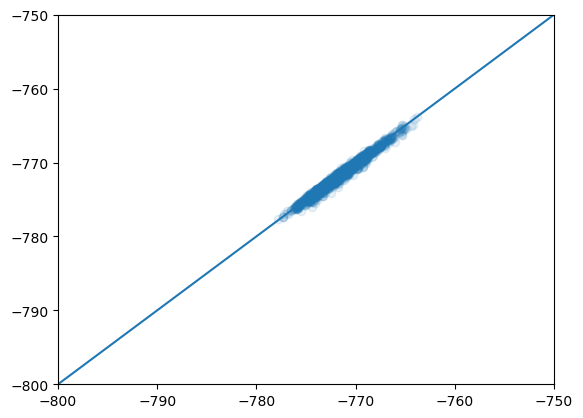

In [40]:
plt.scatter(output["Es"] , output["predEs"], alpha=0.1)
plt.xlim(-800, -750)
plt.ylim(-800, -750)
plt.plot([-800, -750], [-800, -750])

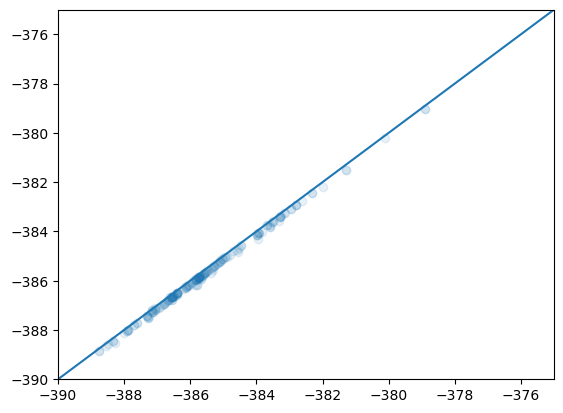

In [41]:
plt.scatter(output["Es"] , output["predEs"], alpha=0.1)
plt.xlim(-390, -375)
plt.ylim(-390, -375)
plt.plot([-390, -375], [-390, -375])

In [ ]:
# get_ase_calc(params, model, ase_mol, conversion=conversion):

In [24]:
Z, R = atomic_numbers, atom_positions
Z = [_ for i, _ in enumerate(Z) if i < 5  ]
R = [_ for i, _ in enumerate(R) if i < 5  ]
ase_atoms_monomer = ase.Atoms(Z, R)
view_atoms(ase_atoms_monomer)

In [25]:
# TODO: add default keys to the conversion dict
ase_calc_monomer = get_ase_calc(params, monomer_model, ase_atoms_monomer, conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol})

In [26]:
ase_atoms_monomer.calc = ase_calc_monomer

In [27]:
float(ase_atoms_monomer.get_potential_energy())

-385.3331298828125

In [28]:
Z, R = atomic_numbers, atom_positions
Z = [_ for i, _ in enumerate(Z) if i < 10  ]
R = [_ for i, _ in enumerate(R) if i < 10  ]
ase_atoms_dimer = ase.Atoms(Z, R)
view_atoms(ase_atoms_dimer)

In [29]:
ase_calc_dimer = get_ase_calc(params, dimer_model, ase_atoms_dimer, conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol})

In [30]:

# dimer_permutations

In [31]:
ase_monomers_dict = {}
e_monomers_dict = {}
for i in range(20):
    start, stop = i*5, i*5 + 5
    Z, R = atomic_numbers, atom_positions
    Z = [_ for i, _ in enumerate(Z) if start <= i < stop  ]
    R = [_ for i, _ in enumerate(R) if start <= i < stop  ]
    ase_atoms_monomer = ase.Atoms(Z, R)
    ase_atoms_monomer.calc = ase_calc_monomer
    ase_monomers_dict[i] = ase_atoms_monomer
    e_monomers_dict[i] = ase_atoms_monomer.get_potential_energy()


In [32]:
# 

In [43]:
monomer_atom_energies = sum( [Eref[z] for z in ase_atoms_monomer.get_atomic_numbers()])
monomer_atom_energies, ase_atoms_monomer.get_atomic_numbers()

(-957.8264263771089, array([ 6,  1,  1, 17, 17]))

In [95]:
ase_dimers_dict = {}
e_dimers_dict = {}

for perm in dimer_permutations:
    a,b = perm
    monomer1 = ase_monomers_dict[a]
    monomer2 = ase_monomers_dict[b]
    ase_atoms_dimer = monomer1 + monomer2
    ase_atoms_dimer.calc = ase_calc_dimer
    ase_dimers_dict[i] = ase_atoms_dimer
    e_dimers_dict[perm] = ase_atoms_dimer.get_potential_energy()

eint_dimers_dict = {}

for perm in dimer_permutations:
    a,b = perm

    tot_e_dimer = e_dimers_dict[perm] 
    monomer1_tot_e = e_monomers_dict[a]
    monomer2_tot_e = e_monomers_dict[b]
    eint_dimers_dict[perm] = tot_e_dimer - (monomer1_tot_e + monomer2_tot_e)

sum_of_monomers = float(sum(list(e_monomers_dict.values())))
sum_of_dimers = float(sum(list(e_dimers_dict.values())))

dimer_intE = float(sum(list(eint_dimers_dict.values())))
sum_of_monomers_total_e = monomer_atom_energies*20 + sum_of_monomers / 627.509

NameError: name 'dimer_permutations' is not defined